In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import binned_statistic

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ev-battery-charging-data/ev_battery_charging_data.csv


In [3]:
df = pd.read_csv("/kaggle/input/ev-battery-charging-data/ev_battery_charging_data.csv")

Conduct A/B Test of two charging modes: Fast Charging and Normal Charging
-  H0: No difference in charging efficiency between fast and normal charging
-  H1: There is a difference in charging efficiency between fast and normal charging

In [4]:
# A
normal_mode = df.loc[df['Charging Mode'] == 'Normal']

# B
fast_mode = df.loc[df['Charging Mode'] == 'Fast']

In [5]:
test_a = normal_mode[["Charging Mode", "Efficiency (%)"]]
test_b = fast_mode[["Charging Mode", "Efficiency (%)"]]

In [6]:
mu_a = test_a["Efficiency (%)"].mean()
mu_b = test_b["Efficiency (%)"].mean()

var_a = test_a["Efficiency (%)"].var()
var_b = test_b["Efficiency (%)"].var()

print('Normal Charging Mean:', mu_a, "\nNormal Charging Variance:", var_a, "\nFast Charging Mean:", mu_b, "\nFast Charging Variance:", var_b)

Normal Charging Mean: 98.00312447060276 
Normal Charging Variance: 0.27827451422510396 
Fast Charging Mean: 98.01130703571023 
Fast Charging Variance: 0.30644130377967155


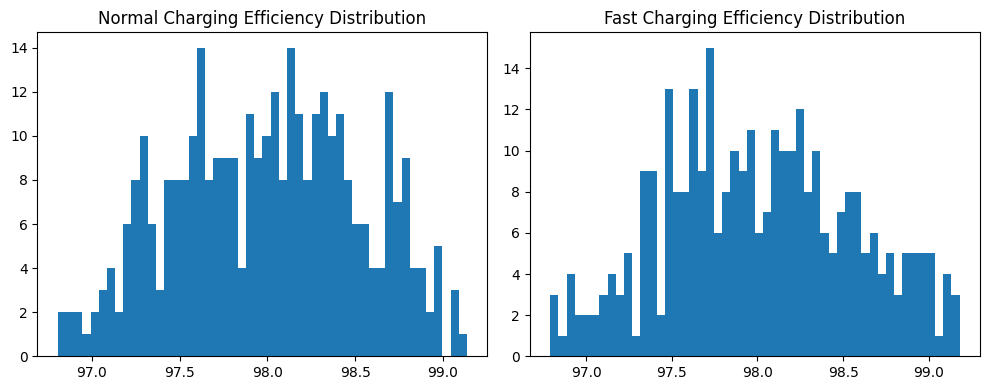

In [7]:
# Analyze distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(test_a["Efficiency (%)"], bins=50)
plt.title('Normal Charging Efficiency Distribution')

plt.subplot(1, 2, 2)
plt.hist(test_b["Efficiency (%)"], bins=50)
plt.title('Fast Charging Efficiency Distribution')
plt.tight_layout()

# Statistical test for normality
from scipy import stats
normal_shapiro = stats.shapiro(test_a["Efficiency (%)"])
fast_shapiro = stats.shapiro(test_b["Efficiency (%)"])

In [8]:
normal_shapiro = stats.shapiro(test_a["Efficiency (%)"])
fast_shapiro = stats.shapiro(test_b["Efficiency (%)"])

print(normal_shapiro)
print(fast_shapiro)

ShapiroResult(statistic=0.9849465645409786, pvalue=0.0012869490741764162)
ShapiroResult(statistic=0.9872817052562275, pvalue=0.006661117048233611)




Assumptions:
- The samples are independent (assuming different charging sessions)
- Sample size is large enough (N>30)
- Unequal Variances

For both charging modes, the p-values (0.001287 and 0.00666) are less than our alpha level of 0.05, which technically suggests non-normality.

However, we can still proceed with Welch's t-test because:

- Sample sizes are relatively large (>30 in each group)
- The histograms show reasonably symmetric, bell-shaped distributions
- Welch's t-test is fairly robust to violations of normality due to the Central Limit Theorem

In [9]:
alpha = 0.05

stats.ttest_ind(test_a['Efficiency (%)'], test_b["Efficiency (%)"], equal_var = False)

TtestResult(statistic=-0.19399523359618992, pvalue=0.8462403295419344, df=648.869845183428)


Such a small t-value suggests a very small differences between our two groups. The negative value indicates that fast charging has a slightly higher efficiency compared to normal charging. The p-value is much larger compared to the significance level of 0,05, therefore we cannot reject the null hypothesis. We have an 85% chance of observing differences by random chance.

This challenges my initial assumption that there would be a diiference between the two charging modes as in traditional batteries the faster the charging, the less efficiency over time. I would like to explore the reasoning behind this a bit more.


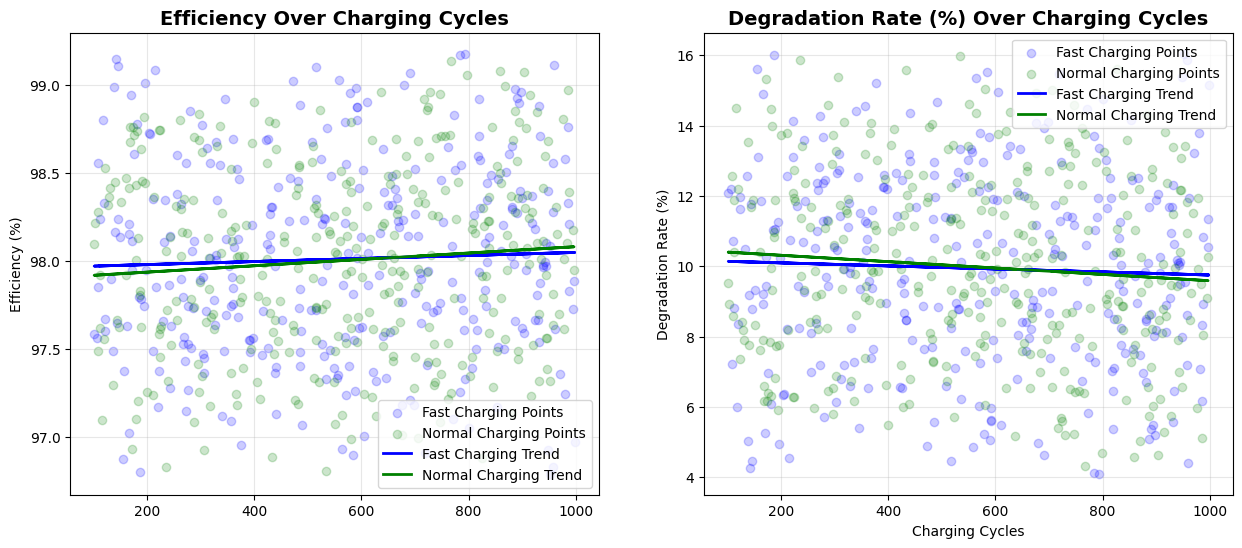

In [10]:
fast_charging = df[df['Charging Mode'].isin(['Fast'])]
normal_charging = df[df['Charging Mode'].isin(['Normal'])]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(fast_charging['Charging Cycles'], fast_charging['Efficiency (%)'], alpha=0.2, color='blue', label='Fast Charging Points')
ax1.scatter(normal_charging['Charging Cycles'], normal_charging['Efficiency (%)'], alpha=0.2, color='green', label='Normal Charging Points')

fast_z = np.polyfit(fast_charging['Charging Cycles'], fast_charging['Efficiency (%)'], 1)
normal_z = np.polyfit(normal_charging['Charging Cycles'], normal_charging['Efficiency (%)'], 1)
fast_p = np.poly1d(fast_z)
normal_p = np.poly1d(normal_z)

ax1.plot(fast_charging['Charging Cycles'], fast_p(fast_charging['Charging Cycles']), 'b-', linewidth=2, label='Fast Charging Trend')
ax1.plot(normal_charging['Charging Cycles'], normal_p(normal_charging['Charging Cycles']), 'g-', linewidth=2, label='Normal Charging Trend')

ax1.grid(True, alpha=0.3)
ax1.set_title("Efficiency Over Charging Cycles", fontsize=14, fontweight='bold')
ax1.set_label("Charging Cycles")
ax1.set_ylabel("Efficiency (%)")
ax1.legend()

ax2.scatter(fast_charging['Charging Cycles'], fast_charging['Degradation Rate (%)'], alpha=0.2, color='blue', label='Fast Charging Points')
ax2.scatter(normal_charging['Charging Cycles'], normal_charging['Degradation Rate (%)'], alpha=0.2, color='green', label='Normal Charging Points')

fast_z = np.polyfit(fast_charging['Charging Cycles'], fast_charging['Degradation Rate (%)'], 1)
normal_z = np.polyfit(normal_charging['Charging Cycles'], normal_charging['Degradation Rate (%)'], 1)
fast_p = np.poly1d(fast_z)
normal_p = np.poly1d(normal_z)

ax2.plot(fast_charging['Charging Cycles'], fast_p(fast_charging['Charging Cycles']), 'b-', linewidth=2, label='Fast Charging Trend')
ax2.plot(normal_charging['Charging Cycles'], normal_p(normal_charging['Charging Cycles']), 'g-', linewidth=2, label='Normal Charging Trend')

ax2.grid(True, alpha=0.3)
ax2.set_title("Degradation Rate (%) Over Charging Cycles", fontsize=14, fontweight='bold')
ax2.set_xlabel("Charging Cycles")
ax2.set_ylabel("Degradation Rate (%)")
ax2.legend()

plt.show()


As we can see that the difference between charging efficiency is marginal. After about 630 cycles do we see normal charging being slightly more efficient.

Efficiency increasing and degradation is decreasing as the number of cycles increases. These are inversly related. However the rate of degredation between the two modes is also quite small. I am assuming that "fast" charging may not be significantly faster. To understand this, I will analyze the 	Voltage (V) and	Current (A) patterns.


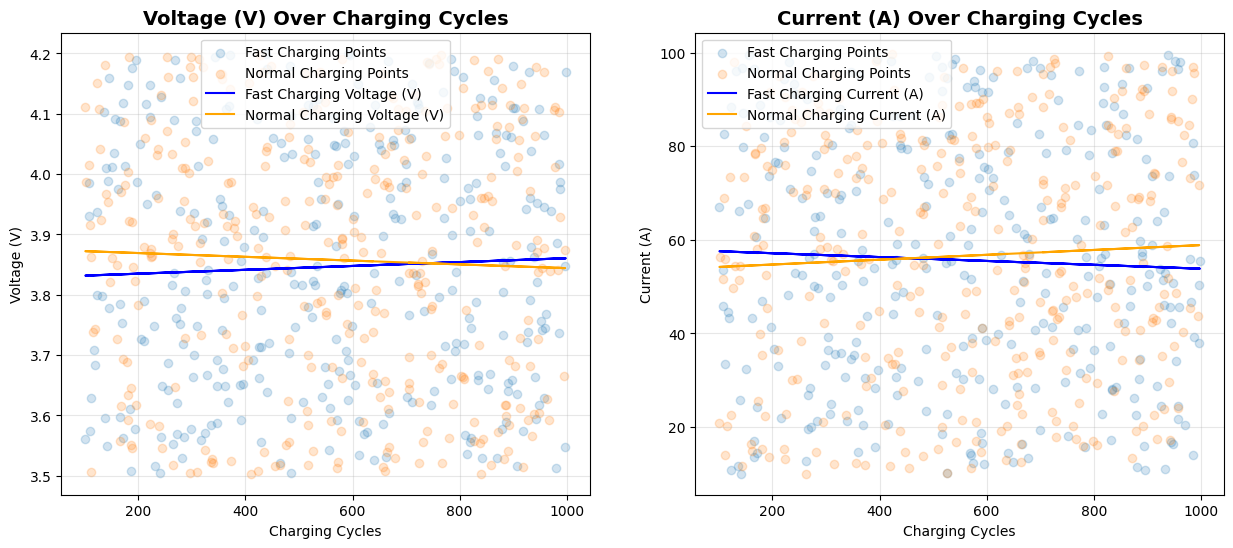

In [11]:
fast_voltage = fast_charging['Voltage (V)']
fast_current = fast_charging['Current (A)']

normal_voltage = normal_charging['Voltage (V)']
normal_current = normal_charging['Current (A)']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Voltage plot
ax1.scatter(fast_charging['Charging Cycles'], fast_voltage, alpha=0.2, label='Fast Charging Points')
ax1.scatter(normal_charging['Charging Cycles'], normal_voltage, alpha=0.2, label='Normal Charging Points')

fast_v = np.polyfit(fast_charging['Charging Cycles'], fast_voltage, 1)
normal_v = np.polyfit(normal_charging['Charging Cycles'], normal_voltage, 1)

fast_volt = np.poly1d(fast_v)
normal_volt = np.poly1d(normal_v)

ax1.plot(fast_charging['Charging Cycles'], fast_volt(fast_charging['Charging Cycles']), 'b-',
         label='Fast Charging Voltage (V)')
ax1.plot(normal_charging['Charging Cycles'], normal_volt(normal_charging['Charging Cycles']), 'orange',
         label='Normal Charging Voltage (V)')

ax1.grid(True, alpha=0.3)
ax1.set_title("Voltage (V) Over Charging Cycles", fontsize=14, fontweight='bold')
ax1.set_xlabel("Charging Cycles")
ax1.set_ylabel("Voltage (V)")
ax1.legend()

# Current plot

ax2.scatter(fast_charging['Charging Cycles'], fast_current, alpha = 0.2, label='Fast Charging Points')
ax2.scatter(normal_charging['Charging Cycles'], normal_current, alpha = 0.2, label='Normal Charging Points')

fast_c = np.polyfit(fast_charging['Charging Cycles'], fast_current,1)
normal_c = np.polyfit(normal_charging['Charging Cycles'], normal_current,1)

fast_current = np.poly1d(fast_c)
normal_current = np.poly1d(normal_c)

ax2.plot(fast_charging['Charging Cycles'],fast_current(fast_charging['Charging Cycles']), 'b-', label = 'Fast Charging Current (A)')
ax2.plot(normal_charging['Charging Cycles'],normal_current( normal_charging['Charging Cycles']), 'orange', label = 'Normal Charging Current (A)')

ax2.grid(True, alpha=0.3)
ax2.set_title("Current (A) Over Charging Cycles", fontsize=14, fontweight='bold')
ax2.set_xlabel("Charging Cycles")
ax2.set_ylabel("Current (A)")
ax2.legend()

plt.show()

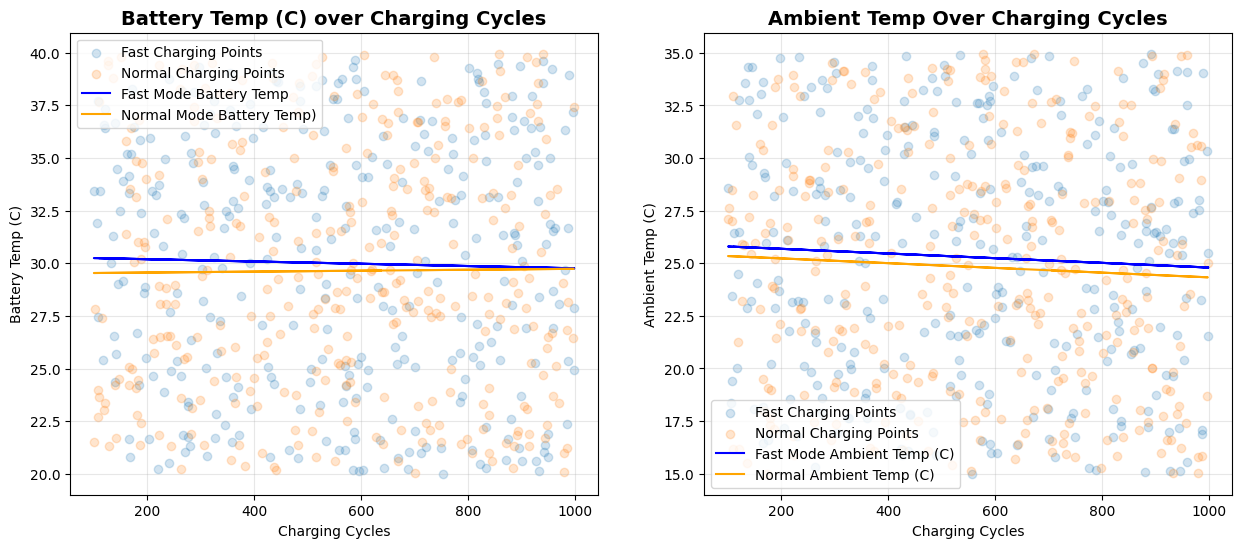

In [12]:
battery_ftemp = fast_charging['Battery Temp (°C)']
ambient_ftemp = fast_charging['Ambient Temp (°C)']

battery_ntemp  = normal_charging['Battery Temp (°C)']
ambient_ntemp  = normal_charging['Ambient Temp (°C)']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(fast_charging['Charging Cycles'], battery_ftemp, alpha=0.2, label='Fast Charging Points')
ax1.scatter(normal_charging['Charging Cycles'], battery_ntemp, alpha=0.2, label='Normal Charging Points')

ftemp = np.polyfit(fast_charging['Charging Cycles'], battery_ftemp, 1)
ntemp = np.polyfit(normal_charging['Charging Cycles'], battery_ntemp, 1)

battery_f = np.poly1d(ftemp)
battery_n = np.poly1d(ntemp)

ax1.plot(fast_charging['Charging Cycles'], battery_f(fast_charging['Charging Cycles']), 'b-',
         label='Fast Mode Battery Temp')
ax1.plot(normal_charging['Charging Cycles'], battery_n(normal_charging['Charging Cycles']), 'orange',
         label='Normal Mode Battery Temp)')

ax1.grid(True, alpha=0.3)
ax1.set_title("Battery Temp (C) over Charging Cycles", fontsize=14, fontweight='bold')
ax1.set_xlabel("Charging Cycles")
ax1.set_ylabel("Battery Temp (C)")
ax1.legend()

ax2.scatter(fast_charging['Charging Cycles'], ambient_ftemp, alpha = 0.2, label='Fast Charging Points')
ax2.scatter(normal_charging['Charging Cycles'], ambient_ntemp, alpha = 0.2, label='Normal Charging Points')

fasta_temp = np.polyfit(fast_charging['Charging Cycles'], ambient_ftemp,1)
normala_temp = np.polyfit(normal_charging['Charging Cycles'], ambient_ntemp,1)

fast_ambient_temp = np.poly1d(fasta_temp)
normal_ambient_temp = np.poly1d(normala_temp)

ax2.plot(fast_charging['Charging Cycles'],fast_ambient_temp(fast_charging['Charging Cycles']), 'b-', label = 'Fast Mode Ambient Temp (C)')
ax2.plot(normal_charging['Charging Cycles'],normal_ambient_temp( normal_charging['Charging Cycles']), 'orange', label = 'Normal Ambient Temp (C)')

ax2.grid(True, alpha=0.3)
ax2.set_title("Ambient Temp Over Charging Cycles", fontsize=14, fontweight='bold')
ax2.set_xlabel("Charging Cycles")
ax2.set_ylabel("Ambient Temp (C)")
ax2.legend()

plt.show()



There's no significant difference in key performance metrics, the distinction between these charging modes appears questionable.

- Efficiency: Both around 98%
- Degradation: Both show similar rates 
- Temperature: Only ~2°C difference
- Voltage/Current patterns: Very similar trends
- Long-term performance: No significant divergence

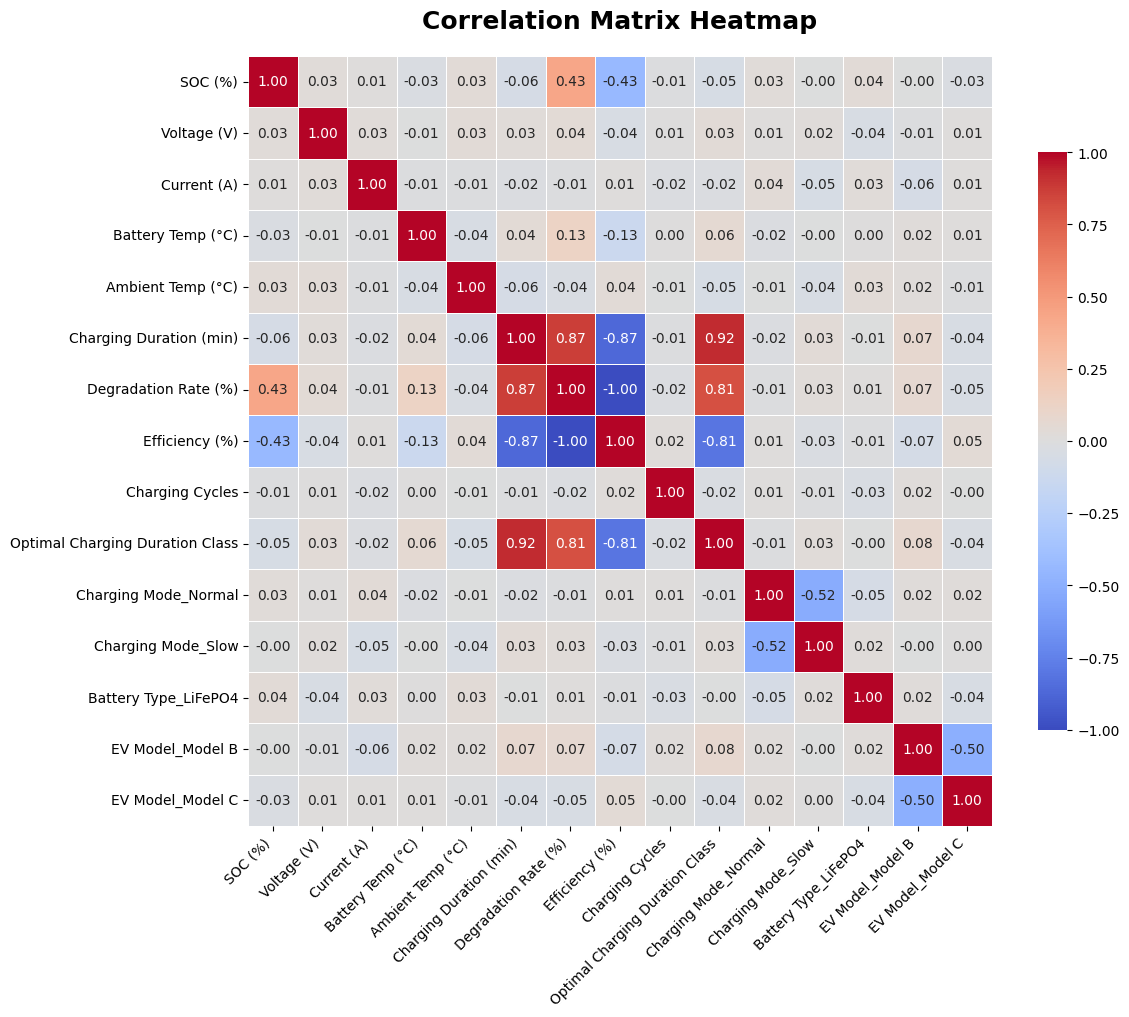

In [13]:
df_dummies = pd.get_dummies(df, drop_first=True)

corr = df_dummies.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',           
            linewidths=0.5,            
            annot_kws={"size": 10},    
            cbar_kws={"shrink": 0.75})

plt.title('Correlation Matrix Heatmap', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.show()

The correlation matrix supports our previous conclusion - the charging mode itself isn't a significant factor. Instead, the total charging duration and its effect on efficiency appear to be the primary drivers of battery degradation, regardless of the chosen mode.